## Часть вторая

Перед вами стоит задача – подготовить аналитический ответ для SMM-отдела компании Skillbox. <br> Объектом анализа является  [паблик Skillbox Вконтакте](https://vk.com/skillbox_education). <br> <br>
Подключитесь к  API VK и выгрузите посты со стены паблика Skillbox за интересующий период (определите самостоятельно и обоснуйте). Проанализируйте влияние различных факторов (например, времени публикации) на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах). Сделайте аналитику по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике. Выбрать нужные посты можно с помощью регулярных выражений. Составьте перечень рекомандаций для SMM-отдела по итогам анализа. <br> <br>

Дополнительные инструкции по работе с API VK расположены [здесь](https://colab.research.google.com/drive/1rRaTay-OSPLAOX8V9UaFvTiAciVtp2s3).

# Подготовка

In [37]:
import re
import os
import requests
import sqlite3

import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid', rc={"xtick.bottom": True})

from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as mdates

vk_token = os.getenv('VK_TOKEN')
conn = sqlite3.connect('database.db')

Загружаем посты и информацию о лайкнувших пользователях в базу данных.
Для начала рассматриваются посты с 2018-го года.

In [38]:
def calc_age(row):
    """Функция для вычисления возраста"""
    date_list = str(row['bdate']).split('.')
    if len(date_list) == 3:
        return datetime.now().year - int(date_list[-1])
    else:
        return None


def get_users_stat(post):

    post_id = post['id']

    # запрашиваем список пользователей, лайкнувших пост
    url = f'https://api.vk.com/method/'\
          f'likes.getList?access_token={vk_token}'\
          f'&type=post&owner_id=-66669811&item_id={post_id}&v=5.92'
    response = requests.get(url).json()
    users = response['response']['items']
    user_str = str(users).replace('[', '').replace(']', '')

    # запрашиваем информацию об этих пользователях
    url = f'https://api.vk.com/method/'\
          f'users.get?access_token={vk_token}'\
          f'&fields=bdate,city,country,sex'\
          f'&user_ids={user_str}&v=5.92'
    response = requests.get(url).json()

    # из ответа формируем датафрейм и добавляем в БД
    users_df = pd.json_normalize(response['response'])

    if len(users_df) > 0:
        # если ни у кого из лайкнувших не указан возраст/город/страна,
        # заполняем столбец значением None
        users_df = users_df.reindex(columns=['sex', 'bdate', 'city.title', 'country.title'])

    users_df['post_id'] = post_id
    users_df['age'] = users_df.apply(lambda row: calc_age(row), axis=1)
    users_df.to_sql('users_activity', conn, if_exists='append', index=False)
    print(f'{offset=}, {post_id=}, {post["date"]=}')


def get_tag(post):
    tags = re.findall(r'#\w+', post['text'])
    return str(tags).replace('[', '').replace(']', '') if tags else None


# id паблика для анализа
public_id = '-66669811'

# загружаем с первого поста по 100 постов - максимум за раз
offset = 0
count = 100

collect_statistics = True

# загружаем посты до указанной даты
until_date = datetime(2018, 1, 1)

while True:
    # отправляем запрос и сохраняем ответ в виде словаря
    url = f'https://api.vk.com/method/wall.get?access_token={vk_token}'\
          f'&owner_id={public_id}'\
          f'&count={count}'\
          f'&offset={offset}'\
          f'&v=5.92'
    response = requests.get(url).json()

    # преобразуем словарь в датафрейм,
    # нормализуем элементы словаря, чтобы получилась "плоская" таблица
    df = pd.json_normalize(response['response']['items'])
    df = df[['id', 'date', 'text', 'comments.count', 'likes.count', 'post_source.type',
             'reposts.count', 'reposts.user_reposted', 'views.count']]
    df.rename(columns={'id': 'post.id'})

    # меняем формат даты
    df['date'] = df.apply(lambda x: datetime.fromtimestamp(x['date']), axis=1)

    # теги добавляем в отдельный столбец
    df['tag'] = df.apply(lambda row: get_tag(row), axis=1)

    # если добрались до нужной даты - останавливаемся
    date = df['date'].min()
    if date < until_date:
        # добавляем полученные посты до until_date в базу данных
        df = df[df['date'] > until_date]
        if collect_statistics:
            df.apply(lambda post: get_users_stat(post), axis=1)
        df.to_sql('posts', conn, if_exists='append', index=False)
        offset += len(df[df['date'] > until_date])
        break

    # иначе - загружаем еще count постов
    else:
        # добавляем все посты в базу данных
        if collect_statistics:
            df.apply(lambda post: get_users_stat(post), axis=1)
        df.to_sql('posts', conn, if_exists='append', index=False)
        offset += count
    print(f'Загружены посты с {offset + 1 - count} по {offset + 1}... '
          f'Загружены посты до {date}')

print(f'Все посты до {date} выгружены. Всего {offset} постов')

# Динамика сообщества
Просмотры, лайки и репосты за все время.

In [39]:
query = """
SELECT date, "views.count", "likes.count", "reposts.count", "comments.count"
FROM posts
"""

data = pd.read_sql(query, conn, parse_dates=['date'])
data = data.resample('w', on='date').median().reset_index()
data.head()

,date,views.count,likes.count,reposts.count,comments.count
0,2018-01-21,8104.0,46.0,3.0,6.0
1,2018-01-28,6913.0,22.0,2.0,2.0
2,2018-02-04,6866.0,57.0,10.0,0.0
3,2018-02-11,6185.0,24.0,1.5,0.5
4,2018-02-18,8134.0,18.0,1.0,3.0


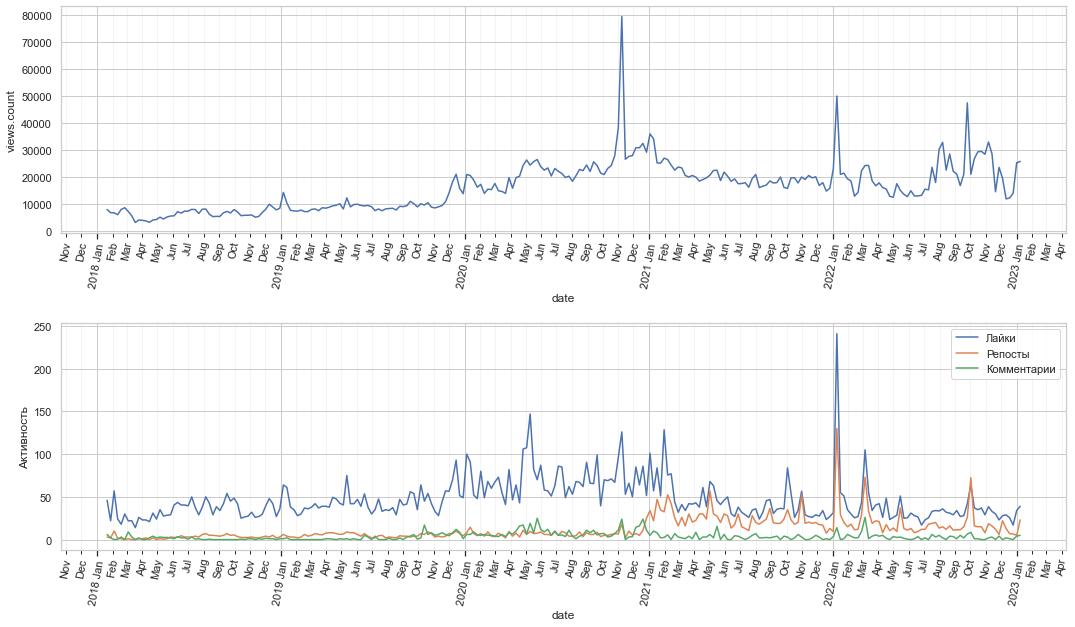

In [40]:
fig, axs = plt.subplots(nrows=2, figsize=(18, 10))
sns.set(style='whitegrid', rc={"xtick.bottom": True})

sns.lineplot(data=data, x='date', y='views.count', ax=axs[0])
sns.lineplot(data=data, x='date', y='likes.count', ax=axs[1], label='Лайки')
sns.lineplot(data=data, x='date', y='reposts.count', ax=axs[1], label='Репосты')
sns.lineplot(data=data, x='date', y='comments.count', ax=axs[1], label='Комментарии')

for ax in axs:
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y %b"))

    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b"))

    ax.tick_params(axis='x', which='both', rotation=80)
    ax.grid(True, which='minor', alpha=0.2)

axs[1].set_ylabel('Активность')

plt.subplots_adjust(hspace=0.4)
plt.show()

1. С начала 2020 года активность выросла - это наиболее интересный участок для дальнейшего анализа.
2. Активность пользователей была наивысшей в 2020 году, при этом сохранялась положительная динамика роста.
3. На графике видны выбросы. Рассмотрим посты, которые их обеспечили:

In [41]:
print('Топ-5 постов по количеству просмотров')
display(pd.read_sql('SELECT * FROM posts ORDER BY "views.count" DESC LIMIT 5', conn, parse_dates=['date']))

print('Топ-5 постов по количеству лайков')
display(pd.read_sql('SELECT * FROM posts ORDER BY "likes.count" DESC LIMIT 5', conn, parse_dates=['date']))

print('Топ-5 постов по количеству комментариев')
display(pd.read_sql('SELECT * FROM posts ORDER BY "comments.count" DESC LIMIT 5', conn, parse_dates=['date']))

Топ-5 постов по количеству просмотров


,post_id,date,text,comments.count,likes.count,post_source.type,reposts.count,reposts.user_reposted,views.count,tag
0,24338,2018-05-23 16:00:11,"Хей-хей, ребята. Мы тут с Лентачом запустили с...",7,917,vk,18,0,1744101,'#test'
1,202013,2021-08-26 10:30:02,Есть разные способы узнать больше о Skillbox. ...,4,246,vk,104,0,1075705,None
2,215343,2021-11-01 13:32:31,"Нет, это не шутка! Попробовать 34 курса и инте...",453,1466,vk,2182,0,210802,None
3,209288,2021-09-28 13:59:24,Научитесь создавать сценарии и постройте карье...,48,211,vk,128,0,165950,None
4,25179,2018-06-14 14:00:12,Работа современного дизайнера уже давно не сво...,7,194,vk,18,0,145413,'#read'


Топ-5 постов по количеству лайков


,post_id,date,text,comments.count,likes.count,post_source.type,reposts.count,reposts.user_reposted,views.count,tag
0,215343,2021-11-01 13:32:31,"Нет, это не шутка! Попробовать 34 курса и инте...",453,1466,vk,2182,0,210802,None
1,30954,2019-01-25 13:00:13,,2,1113,vk,1,0,9218,None
2,251053,2022-07-12 17:39:28,"Мы в Skillbox верим, что каждый достоин второг...",141,1018,api,282,0,117894,'#Жизньпосле'
3,32760,2019-04-07 10:30:00,"Ловите скорее 8 вебинаров, посвященных социаль...",7,978,vk,283,0,73769,None
4,58762,2020-05-06 12:20:16,"Срочно нужна анимация в соцсети, а у дизайнера...",20,946,api,178,0,72536,"'#В_закладки_Skillbox', '#Skillbox_дизайн'"


Топ-5 постов по количеству комментариев


,post_id,date,text,comments.count,likes.count,post_source.type,reposts.count,reposts.user_reposted,views.count,tag
0,272249,2022-11-17 18:10:04,"Как насчет того, чтобы увидеть Дмитрия Нагиева...",2714,158,api,28,0,59576,None
1,251137,2022-07-13 16:30:03,"Кому проходки на VK Fest?\n\nЗнаем, желающих м...",2247,60,api,48,0,48758,None
2,60637,2020-05-13 16:32:38,[club163456906|TEDxDvortsovayaSquare] и Skillb...,802,942,api,113,0,97654,"'#Конкурс_Skillbox', '#Skillbox_TED'"
3,215343,2021-11-01 13:32:31,"Нет, это не шутка! Попробовать 34 курса и инте...",453,1466,vk,2182,0,210802,None
4,259005,2022-09-03 13:05:02,"Сможете перевернуть календарь так, чтобы 4 сен...",442,56,api,5,0,32010,None


# Аналитика по рубрикам

## Лучшие рубрики
Узнаем, какие рубрики наиболее эффективны. Для этого рассмотрим показатели вовлеченности рубрик.

In [57]:
query = """
SELECT post_id, tag, "views.count", "likes.count", "reposts.count", "comments.count",
CAST(strftime('%Y', date) AS INTEGER) as year
FROM posts
WHERE tag NOTNULL
"""

data = pd.read_sql(query, conn, parse_dates=['date'])

tags_count = {}
for row, id in zip(data.tag, data.post_id):
    tag_list = row.split(', ')
    for tag in tag_list:
        tag = tag.lower().replace("'", "")
        if tag in tags_count:
            tags_count[tag][0] += 1
            tags_count[tag][1].append(id)
        else:
            tags_count[tag] = np.array([1, [id]], dtype=object)

tags_count = pd.DataFrame({'count': tags_count.values()}, index=tags_count.keys())
tags_count['post_id'] = tags_count.apply(lambda row: row['count'][1], axis=1)
tags_count['count'] = tags_count.apply(lambda row: row['count'][0], axis=1)

tags_count['views'] = tags_count.apply(lambda row: data[data['post_id'].isin(row.post_id)]['views.count'].median(), axis=1)
tags_count['likes'] = tags_count.apply(lambda row: data[data['post_id'].isin(row.post_id)]['likes.count'].median(), axis=1)
tags_count['comments'] = tags_count.apply(lambda row: data[data['post_id'].isin(row.post_id)]['comments.count'].median(), axis=1)
tags_count['reposts'] = tags_count.apply(lambda row: data[data['post_id'].isin(row.post_id)]['reposts.count'].median(), axis=1)

# считаем рубрику регулярной, если в ней было более 10 постов
tags_count['regular'] = tags_count.apply(lambda row: True if row['count'] > 10 else False, axis=1)

tags_count

,count,post_id,views,likes,comments,reposts,regular
#якаланюсь,1,[279617],25838.0,82.0,7.0,36.0,False
#skillbox_психология,31,"[279617, 279569, 278842, 278513, 278083, 26198...",16526.0,30.0,4.0,25.0,True
#skillbox_дизайн,455,"[279463, 279246, 279057, 279014, 278989, 27850...",19429.0,58.0,4.0,10.0,True
#skillbox_маркетинг,256,"[279060, 264825, 260811, 259519, 259379, 25739...",20712.0,56.0,3.0,12.5,True
#skillbox_киноимузыка,29,"[279055, 276310, 275587, 271785, 271402, 26903...",15516.0,25.0,0.0,11.0,True
...,...,...,...,...,...,...,...
#breakpoint18,1,[22827],3015.0,8.0,0.0,0.0,False
#cила_мысли_в_действии,1,[22827],3015.0,8.0,0.0,0.0,False
#psbattle,3,"[22734, 22728, 22632]",3532.0,19.0,0.0,0.0,False
#freelancing,1,[22667],5123.0,37.0,1.0,1.0,False


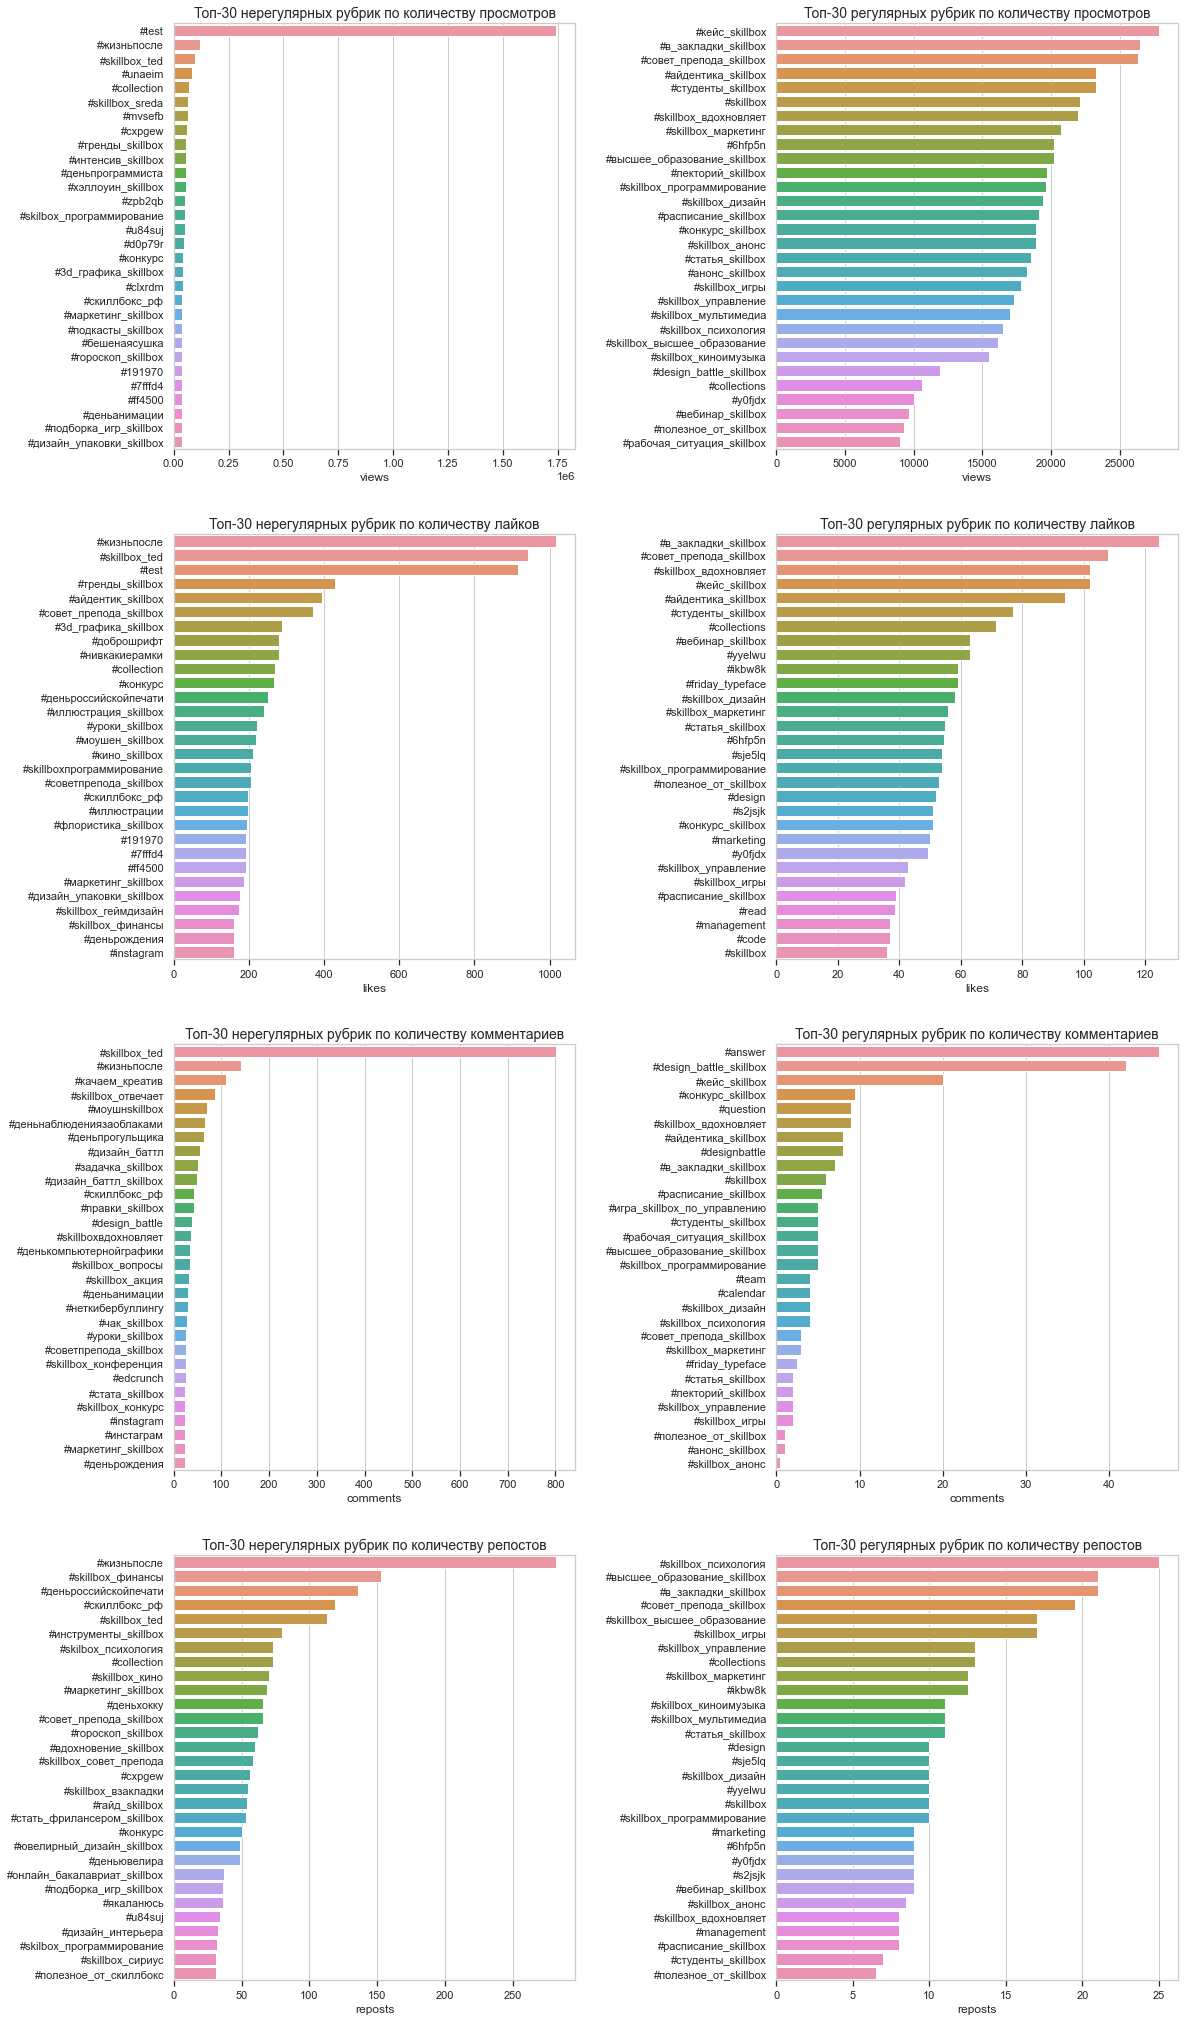

In [44]:
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(18, 9*4))

# рассматриваем просмотры, лайки, комментарии и репосты
for i, name in enumerate(tags_count.columns[2:6]):
    plot = tags_count[tags_count.regular == False].sort_values(name, ascending=False).head(30)
    sns.barplot(data=plot, x=name, y=plot.index, orient='h', ax=axs[i][0])

    plot = tags_count[tags_count.regular == True].sort_values(name, ascending=False).head(30)
    sns.barplot(data=plot, x=name, y=plot.index, orient='h', ax=axs[i][1])

axs[0][0].set_title('Топ-30 нерегулярных рубрик по количеству просмотров', fontsize=14)
axs[0][1].set_title('Топ-30 регулярных рубрик по количеству просмотров', fontsize=14)
axs[1][0].set_title('Топ-30 нерегулярных рубрик по количеству лайков', fontsize=14)
axs[1][1].set_title('Топ-30 регулярных рубрик по количеству лайков', fontsize=14)
axs[2][0].set_title('Топ-30 нерегулярных рубрик по количеству комментариев', fontsize=14)
axs[2][1].set_title('Топ-30 регулярных рубрик по количеству комментариев', fontsize=14)
axs[3][0].set_title('Топ-30 нерегулярных рубрик по количеству репостов', fontsize=14)
axs[3][1].set_title('Топ-30 регулярных рубрик по количеству репостов', fontsize=14)

plt.subplots_adjust(wspace=0.5)
plt.show()

На диаграммах справа указаны наиболее эффективные рубрики для каждого из показателей вовлеченности. На ведение этих рубрик стоит обратить больше внимания. Диаграммы справа могут послужить примерами для составления рубрик или разовых активностей.

## Худшие рубрики
Далее рассмотрим рубрики, на которые можно тратить меньше усилий. Также их стоит учитывать при открытии новых рубрик, чтобы не повторить ошибок.

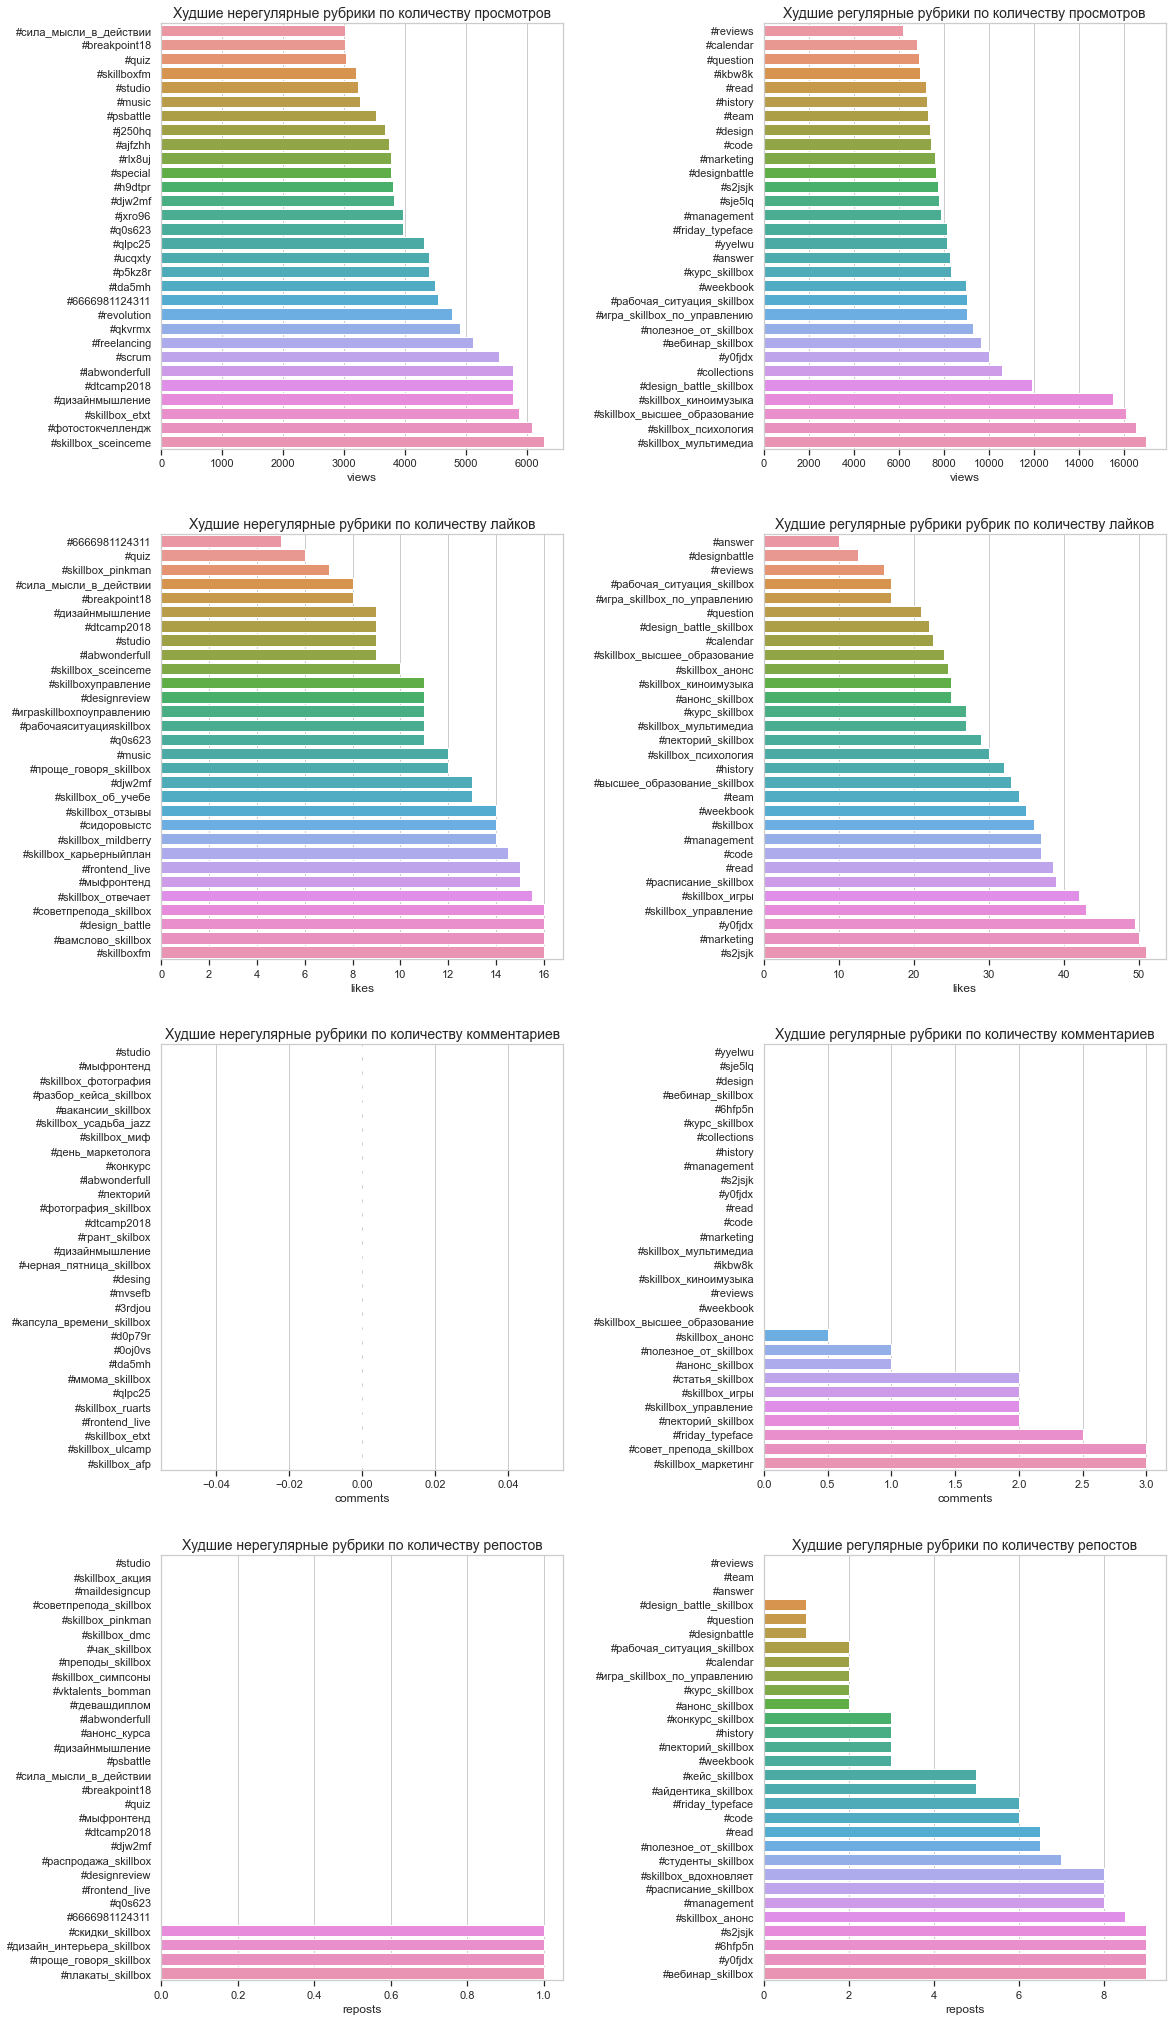

In [56]:
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(18, 9*4))

# рассматриваем просмотры, лайки, комментарии и репосты
for i, name in enumerate(tags_count.columns[2:6]):
    plot = tags_count[tags_count.regular == False].sort_values(name, ascending=True).head(30)
    sns.barplot(data=plot, x=name, y=plot.index, orient='h', ax=axs[i][0])

    plot = tags_count[tags_count.regular == True].sort_values(name, ascending=True).head(30)
    sns.barplot(data=plot, x=name, y=plot.index, orient='h', ax=axs[i][1])

axs[0][0].set_title('Худшие нерегулярные рубрики по количеству просмотров', fontsize=14)
axs[0][1].set_title('Худшие регулярные рубрики по количеству просмотров', fontsize=14)
axs[1][0].set_title('Худшие нерегулярные рубрики по количеству лайков', fontsize=14)
axs[1][1].set_title('Худшие регулярные рубрики рубрик по количеству лайков', fontsize=14)
axs[2][0].set_title('Худшие нерегулярные рубрики по количеству комментариев', fontsize=14)
axs[2][1].set_title('Худшие регулярные рубрики по количеству комментариев', fontsize=14)
axs[3][0].set_title('Худшие нерегулярные рубрики по количеству репостов', fontsize=14)
axs[3][1].set_title('Худшие регулярные рубрики по количеству репостов', fontsize=14)

plt.subplots_adjust(wspace=0.5)
plt.show()

# Оценка времени публикации постов

In [45]:
query = """
SELECT date, "views.count", "likes.count", "reposts.count", "comments.count",
CAST(strftime('%H', date) AS INTEGER) as hour,
CAST(strftime('%Y', date) AS INTEGER) as year
FROM posts
WHERE date < "2023-01-01" AND date >= "2020-01-01"
"""

data = pd.read_sql(query, conn, parse_dates=['date'])
data.head()

,date,views.count,likes.count,reposts.count,comments.count,hour,year
0,2022-12-16 19:00:19,13954,43,14,5,19,2022
1,2022-12-31 12:00:03,18456,37,3,11,12,2022
2,2022-12-30 11:00:00,23865,34,3,0,11,2022
3,2022-12-29 11:30:00,26406,27,3,4,11,2022
4,2022-12-28 13:15:00,26880,45,5,4,13,2022


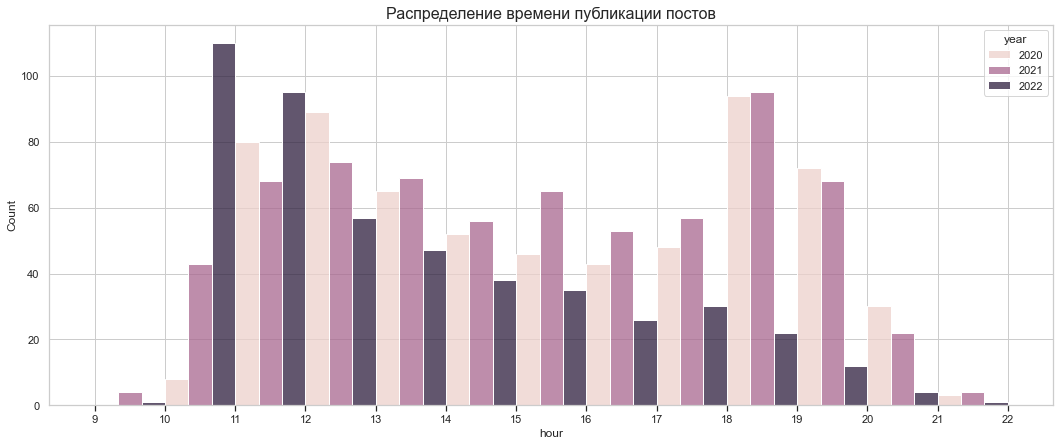

In [46]:
fig, ax = plt.subplots(figsize=(18, 7))
sns.histplot(data=data, x='hour', bins=13, hue='year', multiple='dodge')
ax.set_xticks(data.hour.unique())
ax.set_title('Распределение времени публикации постов', fontsize=16)
plt.show()

В 2022 году количество постов до 12:00 выросло относительно прошлых лет, а количество постов в вечернее время уменьшилось.
Рассмотрим влияние времени публикации на активность пользователей:

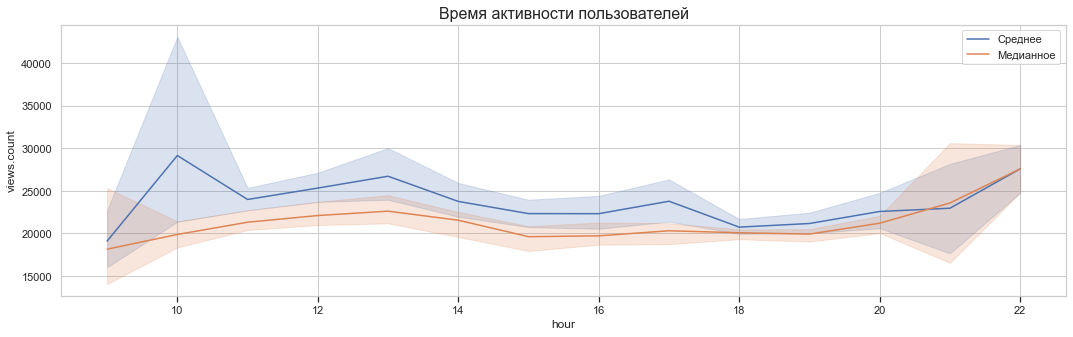

In [47]:
fig, axs = plt.subplots(figsize=(18, 5))
sns.lineplot(data=data, x='hour', y='views.count', estimator='mean', label='Среднее')
sns.lineplot(data=data, x='hour', y='views.count', estimator=np.median, label='Медианное')
axs.set_title('Время активности пользователей', fontsize=16)
plt.show()

In [48]:
query = """
SELECT date, "views.count", "likes.count", "reposts.count", "comments.count",
CAST(strftime('%H', date) AS INTEGER) as hour,
CAST(strftime('%Y', date) AS INTEGER) as year
FROM posts
WHERE date < "2023-01-01" AND date >= "2020-01-01"
"""

data = pd.read_sql(query, conn, parse_dates=['date'])
counts = data.groupby(['hour', 'year'], as_index=False)[['date']].count()
counts.rename(columns={'date': 'posts_count'}, inplace=True)

data = data.merge(counts, left_on=['hour', 'year'], right_on=['hour', 'year'], how='right')

data = data.groupby(['hour', 'year'], as_index=False).median()
data['views/post'] = data['views.count'] / data['posts_count']
data['likes/post'] = data['likes.count'] / data['posts_count']
data['reposts/post'] = data['reposts.count'] / data['posts_count']
data['comments/post'] = data['comments.count'] / data['posts_count']
data.head()

,hour,year,views.count,likes.count,reposts.count,comments.count,posts_count,views/post,likes/post,reposts/post,comments/post
0,9,2021,19586.5,46.5,14.5,2.0,4.0,4896.625000,11.625000,3.625000,0.500000
1,9,2022,16956.0,87.0,20.0,8.0,1.0,16956.000000,87.000000,20.000000,8.000000
2,10,2020,23731.0,61.5,5.5,18.5,8.0,2966.375000,7.687500,0.687500,2.312500
3,10,2021,19797.0,54.0,29.0,4.0,43.0,460.395349,1.255814,0.674419,0.093023
4,10,2022,19325.5,31.0,15.0,3.0,110.0,175.686364,0.281818,0.136364,0.027273


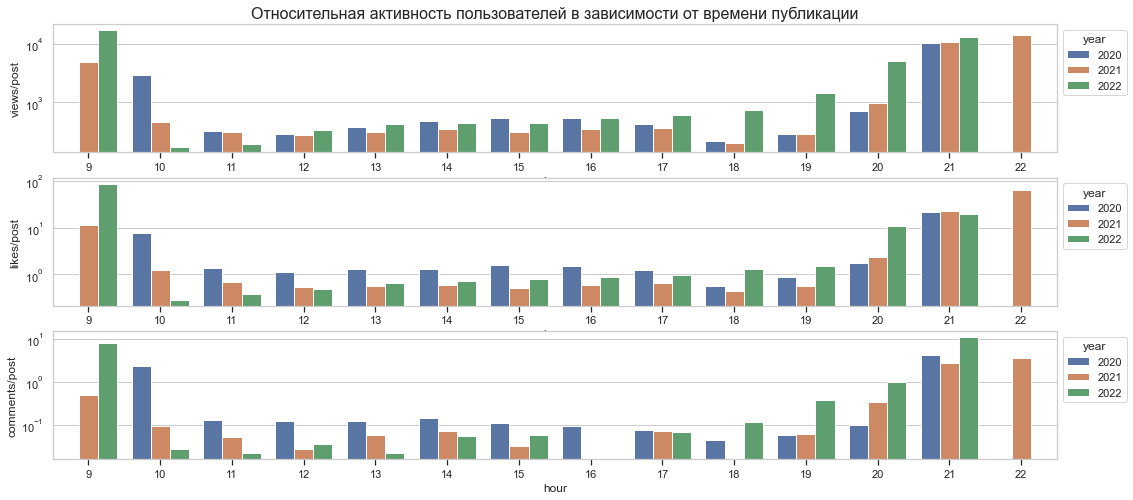

In [49]:
fig, axs = plt.subplots(nrows=3, figsize=(18, 8))

sns.barplot(data=data, x='hour', y='views/post', hue='year', ax=axs[0])
sns.barplot(data=data, x='hour', y='likes/post', hue='year', ax=axs[1])
sns.barplot(data=data, x='hour', y='comments/post', hue='year', ax=axs[2])

for ax in axs:
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set_yscale('log')

axs[0].set_title('Относительная активность пользователей в зависимости от времени публикации', fontsize=16)
plt.show()

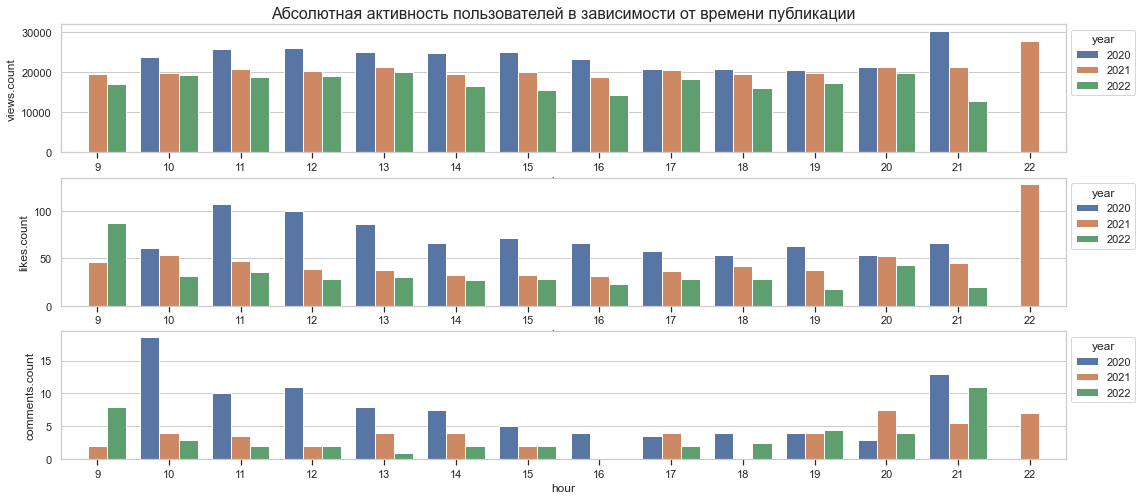

In [50]:
fig, axs = plt.subplots(nrows=3, figsize=(18, 8))

sns.barplot(data=data, x='hour', y='views.count', hue='year', ax=axs[0])
sns.barplot(data=data, x='hour', y='likes.count', hue='year', ax=axs[1])
sns.barplot(data=data, x='hour', y='comments.count', hue='year', ax=axs[2])

for ax in axs:
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    #ax.set_yscale('log')

axs[0].set_title('Абсолютная активность пользователей в зависимости от времени публикации', fontsize=16)
plt.show()

## Выводы
Распределение времени публикации постов в 2022 году отличается от распределения в двух предыдущих годах - постов до 12:00 стало больше, постов после 12:00 стало меньше.

Увеличение количества постов в утреннее время не привело ни к росту относительной, ни к росту абсолютной активности. Вероятно, имеет смысл сократить количество публикаций в утреннее время до величины прошлых лет.

В 2022 году в дневное и вечернее время относительная активность повысилась, но абсолютная активность снизилась из-за малого количества постов. С целью увеличения абсолютной активности рекомендуется увеличивать количество постов в вечернее время, пока относительная активность не начнет падать.


# Статистика пользователей

## Демография участников

In [51]:
# ALTER TABLE posts
# RENAME COLUMN id TO post_id;

query = """
SELECT age, sex, "city.title", "country.title", CAST(strftime('%Y', date) AS INTEGER) as year
FROM users_activity LEFT JOIN posts
ON users_activity.post_id = posts.post_id
WHERE date < "2023-01-01"
"""

data = pd.read_sql(query, conn)
data = data[(data['age'] < data['age'].quantile(0.98)) & (data['sex'] != 0)]
data['sex'] = data.apply(lambda row: 'female' if row.sex == 1 else 'male', axis=1)
data.head()

,age,sex,city.title,country.title,year
2,23.0,female,None,None,2022
3,38.0,female,None,None,2022
7,18.0,female,None,Россия,2022
8,44.0,female,None,Россия,2022
9,50.0,female,Langres,Франция,2022


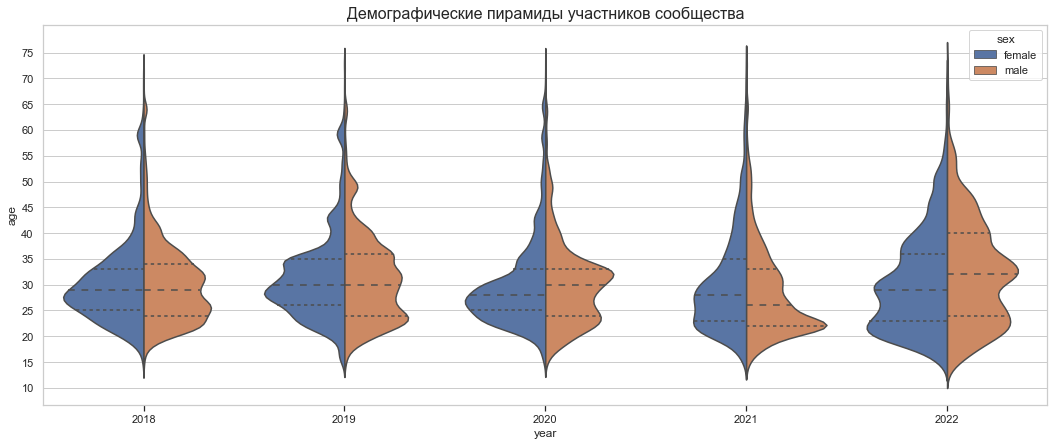

In [52]:
fig, ax = plt.subplots(figsize=(18, 7))
sns.violinplot(data=data, x='year', y='age', hue='sex', split=True, inner='quartile')
ax.set_yticks(range(10, 80, 5))
ax.set_title('Демографические пирамиды участников сообщества', fontsize=16)
plt.show()

In [53]:
data[(data.sex == 'male') & (data.year == 2022)][['age']].describe().merge(
    data[(data.sex == 'female') & (data.year == 2022)][['age']].describe(),
    left_index=True, right_index=True, suffixes=['_male', '_female'])

,age_male,age_female
count,3302.000000,4056.000000
mean,32.368262,30.393491
std,10.162213,9.427823
min,14.000000,15.000000
25%,24.000000,23.000000
50%,32.000000,29.000000
75%,40.000000,36.000000
max,73.000000,70.000000


На демографических пирамидах видны колебания от года к году, которые могут быть вызваны как контентом паблика, так и внешними факторами. Рекомендуется сравнить полученные пирамиды с пирамидами покупателей курсов, чтобы понять, на какую группу участников стоит ориентировать контент.

## География участников

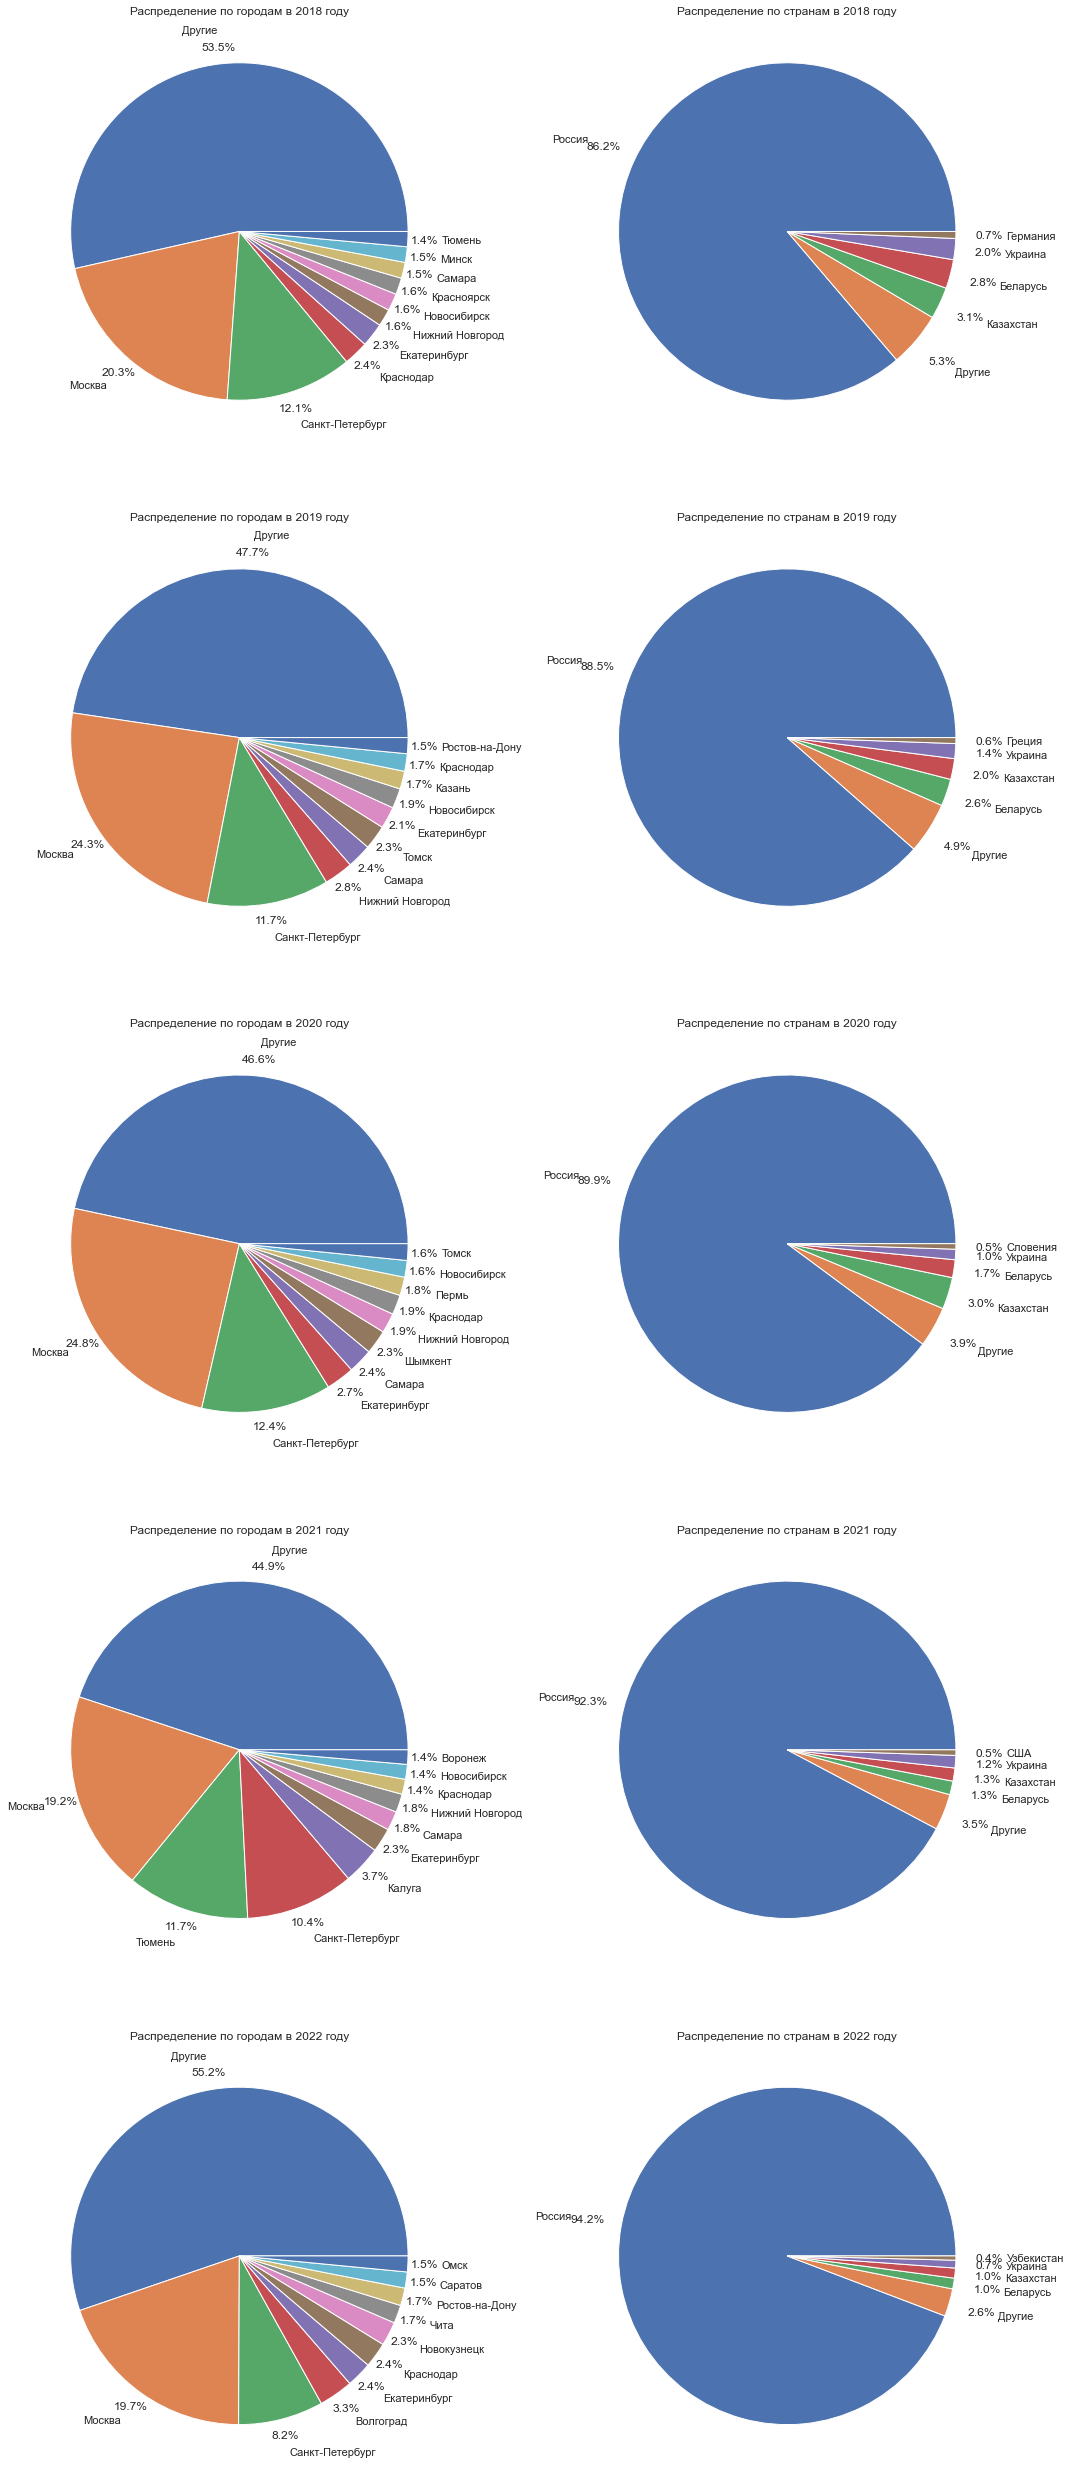

In [54]:
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(18, 9*5))

years = data.year.unique()
years.sort()
years

for i, year in enumerate(years):

    city_data = data[data.year == year].dropna(subset=['city.title'], axis=0)
    popular_cities = city_data['city.title'].value_counts()[:10]
    city_data['city.title'] = city_data\
        .apply(lambda row: row['city.title'] if row['city.title'] in popular_cities else 'Другие', axis=1)
    city_data['city.title'].value_counts().plot.pie(ax=axs[i][0],
                                                    title=f'Распределение по городам в {year} году',
                                                    labeldistance=1.2,
                                                    autopct='%.1f%%',
                                                    pctdistance=1.1)
    axs[i][0].set_ylabel('')

    country_data = data[data.year == year].dropna(subset=['country.title'], axis=0)
    popular_countries = country_data['country.title'].value_counts()[:5]
    country_data['country.title'] = country_data\
        .apply(lambda row: row['country.title'] if row['country.title'] in popular_countries else 'Другие', axis=1)
    country_data['country.title'].value_counts().plot.pie(ax=axs[i][1],
                                                          title=f'Распределение по странам в {year} году',
                                                          labeldistance=1.3,
                                                          autopct='%.1f%%',
                                                          pctdistance=1.2)
    axs[i][1].set_ylabel('')

plt.show()